In [1]:
%matplotlib inline

# Quick fits for TESS FFI light curves

### Big ol' warning: this probably won't work unless you already know this star has a transiting planet. 

In this tutorial, we will fit the TESS light curve for a known transiting planet.
While the :ref:`tess` tutorial goes through the full details of an end-to-end fit, this tutorial is significantly faster to run and it can give pretty excellent results depending on your goals.
Some of the main differences are:

1. We <s>start from the light curve rather than doing</s> **do** the photometry ourselves (for FFIs, or maybe we'll use Eleanor). This should pretty much always be fine unless you have a very bright, faint, or crowded target.
2. We assume a circluar orbit, but as you'll see later, we can approximately relax this assumption later.
3. We only fit the data near transit. In many cases this will be just fine, but if you have predictable stellar variability (like coherent rotation) then you might do better fitting more data.

First, let's download the TESS light curve using [lightkurve](https://docs.lightkurve.org/):

In [2]:
import numpy as np
import lightkurve as lk
import matplotlib.pyplot as plt
import warnings

In [3]:
def simple_regression(tpf):
    """
    Simple de-trending using background pixel regressors.

    The steps of this de-trending are:
     - Find a threshold aperture mask around the target
     - Create a design matrix with column vectors from pixel-level timeseries outside of the aperture
     - Perform Principle Component Analysis (PCA) on column vectors to identify background model vectors
     - Fit weights to these vectors to minimize squared difference between model and observations
     - Subtract noise model

    Parameters
    ----------
    tpf : `lightkurve.TargetPixelFile` object
        target pixel file for desired target

    Returns
    -------
    corrected_lc : `lightkurve.LightCurve` object
        background-corrected light curve
    """
    aper = tpf._parse_aperture_mask('threshold')
    raw_lc = tpf.to_lightcurve(aperture_mask=aper).remove_nans()
    mask = raw_lc.flux_err > 0
    raw_lc = raw_lc[mask]
    tpf = tpf[mask]

    regressors = tpf.flux[:, ~aper]
    regressors = np.array([r[np.isfinite(r)] for r in regressors])

    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', message='.*low rank.*')
        dm = lk.DesignMatrix(regressors, name='regressors')

    dm = dm.pca(10)
    dm = dm.append_constant()

    corrector = lk.RegressionCorrector(raw_lc.normalize())
    corrected_lc = corrector.correct(dm)

    return corrected_lc

In [4]:
ticid = 230001847
search = lk.search_tesscut(f'TIC {ticid}')
tpfc = lk.TargetPixelFileCollection([])

for sector in search:
    try:
        tpfc.append(sector.download(cutout_size=11))
    except:
        continue # won't fail for bad sectors

tpf = tpfc[0]

lc = simple_regression(tpf).flatten(201) # hacky flatten
raw_lc = tpf.to_lightcurve(aperture_mask='threshold')

# store as LCC with sector breakpoints for plotting later
lcc = lk.LightCurveCollection([lc])
breakpoints = [lc.time[-1].value]
for tpf in tpfc[1:]:
    new_lc = simple_regression(tpf).flatten(201)
    new_raw_lc = tpf.to_lightcurve(aperture_mask='threshold')
    breakpoints.append(new_lc.time[-1].value)
    lcc.append(new_lc)
    lc = lc.append(new_lc)
    raw_lc = raw_lc.append(new_raw_lc)

lc = lc
raw_lc = raw_lc

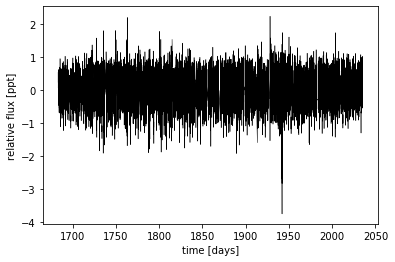

In [5]:
x = np.ascontiguousarray(lc.time.value, dtype=np.float64)
y = np.ascontiguousarray(1e3 * (lc.flux.value - 1), dtype=np.float64)
yerr = np.ascontiguousarray(1e3 * lc.flux_err.value, dtype=np.float64)

texp = np.min(np.diff(x))

plt.plot(x, y, "k", linewidth=0.5)
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]");

Then, find the period, phase and depth of the transit using box least squares:

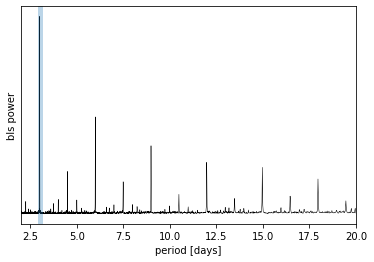

In [6]:
import exoplanet as xo

pg = xo.estimators.bls_estimator(x, y, yerr, min_period=2, max_period=20)

peak = pg["peak_info"]
period_guess = peak["period"]
t0_guess = peak["transit_time"]
depth_guess = peak["depth"]

plt.plot(pg["bls"].period, pg["bls"].power, "k", linewidth=0.5)
plt.axvline(period_guess, alpha=0.3, linewidth=5)
plt.xlabel("period [days]")
plt.ylabel("bls power")
plt.yticks([])
plt.xlim(pg["bls"].period.min(), pg["bls"].period.max());

Then, for efficiency purposes, let's extract just the data within 0.25 days of the transits:

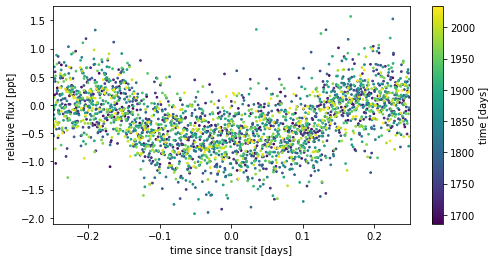

In [7]:
transit_mask = (
    np.abs((x - t0_guess + 0.5 * period_guess) % period_guess - 0.5 * period_guess)
    < 0.25
)
x = np.ascontiguousarray(x[transit_mask])
y = np.ascontiguousarray(y[transit_mask])
yerr = np.ascontiguousarray(yerr[transit_mask])

plt.figure(figsize=(8, 4))
x_fold = (x - t0_guess + 0.5 * period_guess) % period_guess - 0.5 * period_guess
plt.scatter(x_fold, y, c=x, s=3)
plt.xlabel("time since transit [days]")
plt.ylabel("relative flux [ppt]")
plt.colorbar(label="time [days]")
plt.xlim(-0.25, 0.25);

That looks a little janky, but it's good enough for now.

## The probabilistic model

Here's how we set up the PyMC3 model in this case:

In [8]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:

    # Stellar parameters
    mean = pm.Normal("mean", mu=0.0, sigma=10.0)
    u = xo.distributions.QuadLimbDark("u")
    star_params = [mean, u]

    # Gaussian process noise model
    sigma = pm.InverseGamma("sigma", alpha=3.0, beta=2 * np.median(yerr))
    log_Sw4 = pm.Normal("log_Sw4", mu=0.0, sigma=10.0)
    log_w0 = pm.Normal("log_w0", mu=np.log(2 * np.pi / 10.0), sigma=10.0)
    kernel = xo.gp.terms.SHOTerm(log_Sw4=log_Sw4, log_w0=log_w0, Q=1.0 / 3)
    noise_params = [sigma, log_Sw4, log_w0]

    # Planet parameters
    log_ror = pm.Normal("log_ror", mu=0.5 * np.log(depth_guess * 1e-3), sigma=10.0)
    ror = pm.Deterministic("ror", tt.exp(log_ror))

    # Orbital parameters
    log_period = pm.Normal("log_period", mu=np.log(period_guess), sigma=1.0)
    t0 = pm.Normal("t0", mu=t0_guess, sigma=1.0)
    log_dur = pm.Normal("log_dur", mu=np.log(0.1), sigma=10.0)
    b = xo.distributions.ImpactParameter("b", ror=ror)

    period = pm.Deterministic("period", tt.exp(log_period))
    dur = pm.Deterministic("dur", tt.exp(log_dur))

    # Set up the orbit
    orbit = xo.orbits.KeplerianOrbit(period=period, duration=dur, t0=t0, b=b)

    # We're going to track the implied density for reasons that will become clear later
    pm.Deterministic("rho_circ", orbit.rho_star)

    # Set up the mean transit model
    star = xo.LimbDarkLightCurve(u)

    def lc_model(t):
        return mean + 1e3 * tt.sum(
            star.get_light_curve(orbit=orbit, r=ror, t=t), axis=-1
        )

    # Finally the GP observation model
    gp = xo.gp.GP(kernel, x, yerr ** 2 + sigma ** 2, mean=lc_model)
    gp.marginal("obs", observed=y)

    # Double check that everything looks good - we shouldn't see any NaNs!
    print(model.check_test_point())

    # Optimize the model
    map_soln = model.test_point
    map_soln = xo.optimize(map_soln, [sigma])
    map_soln = xo.optimize(map_soln, [log_ror, b, log_dur])
    map_soln = xo.optimize(map_soln, noise_params)
    map_soln = xo.optimize(map_soln, star_params)
    map_soln = xo.optimize(map_soln)

/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


mean                  -3.22
u_quadlimbdark__      -2.77
sigma_log__           -0.53
log_Sw4               -3.22
log_w0                -3.22
log_ror               -3.22
log_period            -0.92
t0                    -0.92
log_dur               -3.22
b_impact__            -1.39
obs                -2048.15
Name: Log-probability of test_point, dtype: float64


optimizing logp for variables: [sigma]


/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


message: Optimization terminated successfully.
logp: -2070.7876658338805 -> -2069.2746507744023
optimizing logp for variables: [log_dur, b, log_ror]


/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


message: Optimization terminated successfully.
logp: -2069.2746507744023 -> -1645.0109450340062
optimizing logp for variables: [log_w0, log_Sw4, sigma]


/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Optimization terminated successfully.
logp: -1645.0109450340062 -> -1388.3467043436121


optimizing logp for variables: [u, mean]


/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Optimization terminated successfully.
logp: -1388.3467043436121 -> -1382.361026860139


optimizing logp for variables: [b, log_dur, t0, log_period, log_ror, log_w0, log_Sw4, sigma, u, mean]


/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: -1382.361026860139 -> -1375.1188894207985


Now we can plot our initial model:

/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


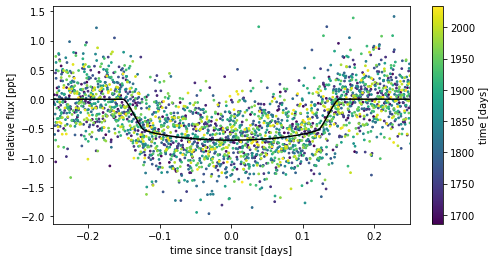

In [9]:
with model:
    gp_pred, lc_pred = xo.eval_in_model([gp.predict(), lc_model(x)], map_soln)

plt.figure(figsize=(8, 4))
x_fold = (x - map_soln["t0"] + 0.5 * map_soln["period"]) % map_soln[
    "period"
] - 0.5 * map_soln["period"]
inds = np.argsort(x_fold)
plt.scatter(x_fold, y - gp_pred - map_soln["mean"], c=x, s=3)
plt.plot(x_fold[inds], lc_pred[inds] - map_soln["mean"], "k")
plt.xlabel("time since transit [days]")
plt.ylabel("relative flux [ppt]")
plt.colorbar(label="time [days]")
plt.xlim(-0.25, 0.25);

That looks better!

Now on to sampling:

In [10]:
np.random.seed(286923464)
with model:
    trace = xo.sample(tune=500, draws=500, start=map_soln, chains=2) # cranked way down for testing

/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [b, log_dur, t0, log_period, log_ror, log_w0, log_Sw4, sigma, u, mean]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [30:04<00:00,  1.11draws/s]
/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
The accep

Then we can take a look at the summary statistics:

In [11]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mean,0.072,0.015,0.045,0.103,0.002,0.001,82.0,81.0,83.0,116.0,1.03
log_Sw4,-2.652,0.096,-2.837,-2.500,0.057,0.045,3.0,3.0,3.0,13.0,1.87
log_w0,0.501,0.074,0.377,0.650,0.042,0.033,3.0,3.0,3.0,37.0,1.68
log_ror,-3.561,0.020,-3.599,-3.523,0.006,0.004,13.0,13.0,12.0,75.0,1.12
log_period,1.097,0.000,1.097,1.097,0.000,0.000,622.0,622.0,625.0,713.0,1.00
t0,1686.026,0.003,1686.022,1686.031,0.000,0.000,480.0,480.0,477.0,713.0,1.00
log_dur,-1.287,0.011,-1.308,-1.267,0.001,0.001,123.0,123.0,127.0,208.0,1.02
u[0],0.701,0.057,0.598,0.796,0.028,0.022,4.0,4.0,4.0,17.0,1.40
u[1],-0.056,0.034,-0.106,0.020,0.018,0.014,4.0,4.0,4.0,18.0,1.43
sigma,0.062,0.009,0.046,0.080,0.005,0.004,3.0,3.0,3.0,21.0,1.94


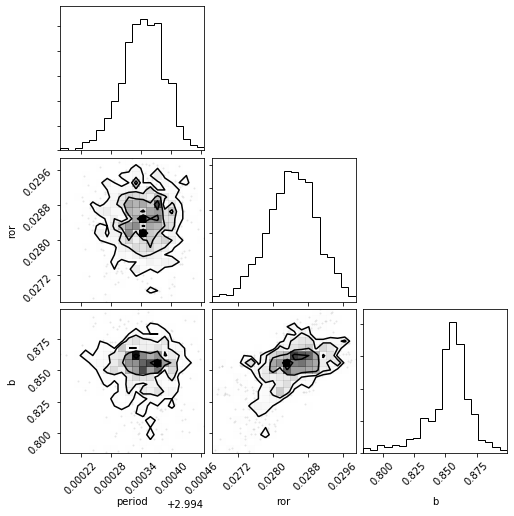

In [15]:
import corner

samples = pm.trace_to_dataframe(trace, varnames=["period", "ror", "b"])
corner.corner(samples);

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [12]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:agol19, exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:foremanmackey17, exoplanet:foremanmackey18,
exoplanet:kipping13, exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


In [13]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Daniel Foreman-Mackey and Rodrigo Luger and Ian Czekala and
            Eric Agol and Adrian Price-Whelan and Tom Barclay},
   title = {exoplanet-dev/exoplanet v0.3.2},
   month = may,
    year = 2020,
     doi = {10.5281/zenodo.1998447},
     url = {https://doi.org/10.5281/zenodo.1998447}
}
...
